<a href="https://colab.research.google.com/github/dn3ndra/DeepLearning/blob/main/UTS/FishImageDataset/ClassificationCNN-FishImageDataset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras import layers, models
import numpy as np
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, recall_score, precision_score, confusion_matrix, accuracy_score
import seaborn as sns

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
base_dir = '/content/drive/MyDrive/FishImgDataset'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=3.6,                 # ~0.01 rotasi
    zoom_range=0.05,
    horizontal_flip=True,
    brightness_range=[0.95, 1.05],      # ~±0.05 brightness
    shear_range=0.0,                    # opsional
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.


Kelas ikan: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


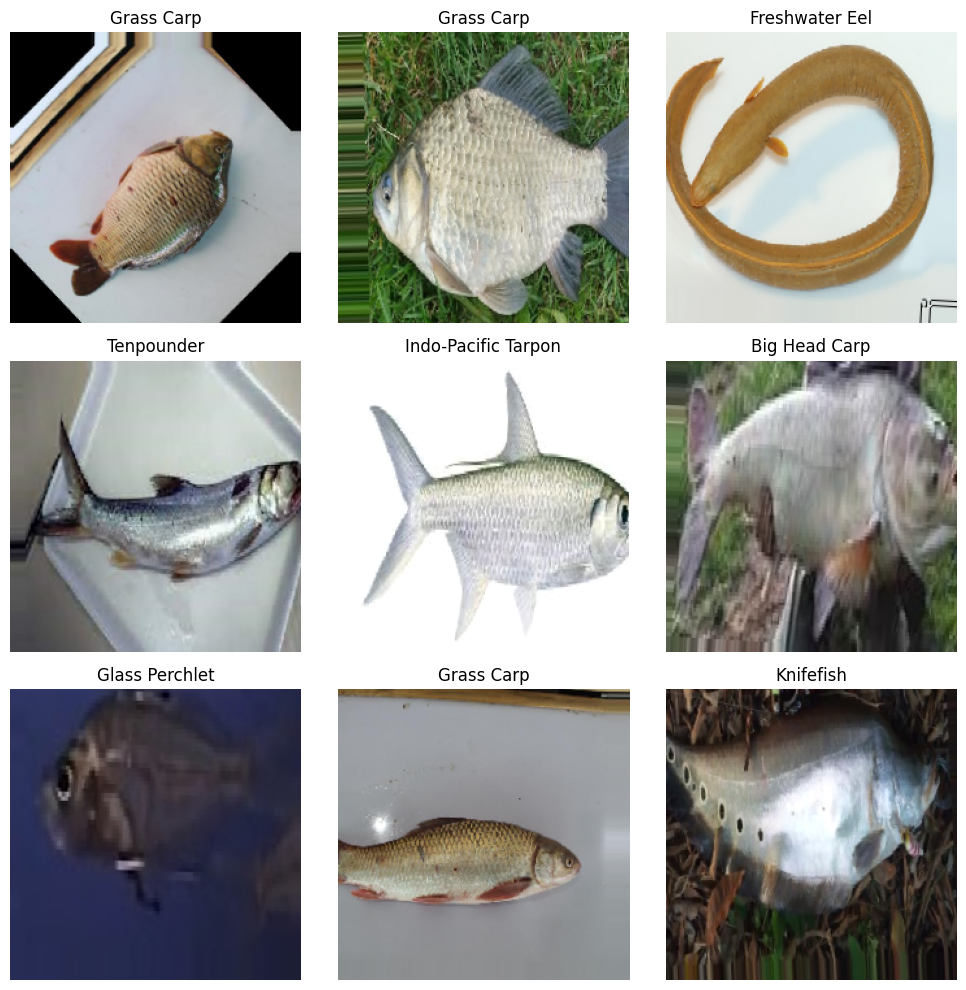

In [19]:
class_names = list(train_generator.class_indices.keys())

num_classes = len(class_names)
print("Kelas ikan:", class_names)

# Ambil satu batch dari train_generator
images, labels = next(train_generator)

# Tampilkan 9 gambar pertama
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


# CNN Model

In [20]:
cnn_model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    # Classifier
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(31, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [22]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)
]

history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 4423s 16s/step - accuracy: 0.1714 - loss: 3.6058 - val_accuracy: 0.0887 - val_loss: 4.6271 - learning_rate: 0.0010
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 204s 738ms/step - accuracy: 0.2812 - loss: 2.7491 - val_accuracy: 0.2897 - val_loss: 2.5436 - learning_rate: 0.0010
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 202s 731ms/step - accuracy: 0.3506 - loss: 2.3875 - val_accuracy: 0.4049 - val_loss: 2.1084 - learning_rate: 0.0010
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 203s 735ms/step - accuracy: 0.4077 - loss: 2.1049 - val_accuracy: 0.4457 - val_loss: 1.8523 - learning_rate: 0.0010
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 202s 731ms/step - accuracy: 0.4612 - loss: 1.8921 - val_accuracy: 0.5187 - val_loss: 1.6512 - learning_rate: 0.0010
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 202s 732ms/step - accuracy: 0.4934 - loss: 1.7725 - val_accuracy: 0.5743 - val_loss: 1.4473 - learning_rate: 0.0010
Epoch 7/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 208s 754ms/step - accurac

In [23]:
import numpy as np

# Melakukan prediksi dengan model
y_pred_probs = cnn_model.predict(test_generator, verbose=0)

# Mengambil kelas yang diprediksi (argmax) dari probabilitas prediksi
y_pred = np.argmax(y_pred_probs, axis=1)

y_test = test_generator.classes

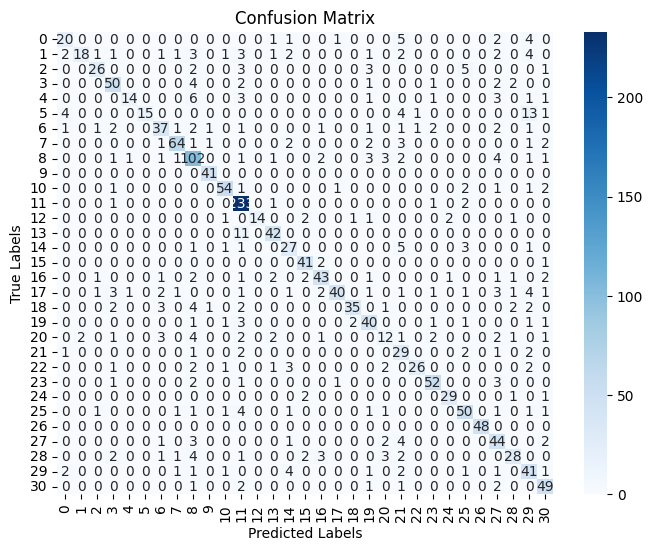


Accuracy: 0.7750
Precision: 0.7941
Recall: 0.7750
F1 Score: 0.7715
ROC AUC Score: 0.9841


In [24]:
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, recall_score, precision_score, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


# Menghitung metrik evaluasi
cnn_acc = accuracy_score(y_test, y_pred)
cnn_precision = precision_score(y_test, y_pred, average='weighted')
cnn_recall = recall_score(y_test, y_pred, average='weighted')
cnn_f1 = f1_score(y_test, y_pred, average='weighted')
cnn_roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')

# Visualisasi dengan Seaborn (Heatmap Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan hasil metrik
print(f"\nAccuracy: {cnn_acc:.4f}")
print(f"Precision: {cnn_precision:.4f}")
print(f"Recall: {cnn_recall:.4f}")
print(f"F1 Score: {cnn_f1:.4f}")
print(f"ROC AUC Score: {cnn_roc_auc:.4f}")

Unique labels in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


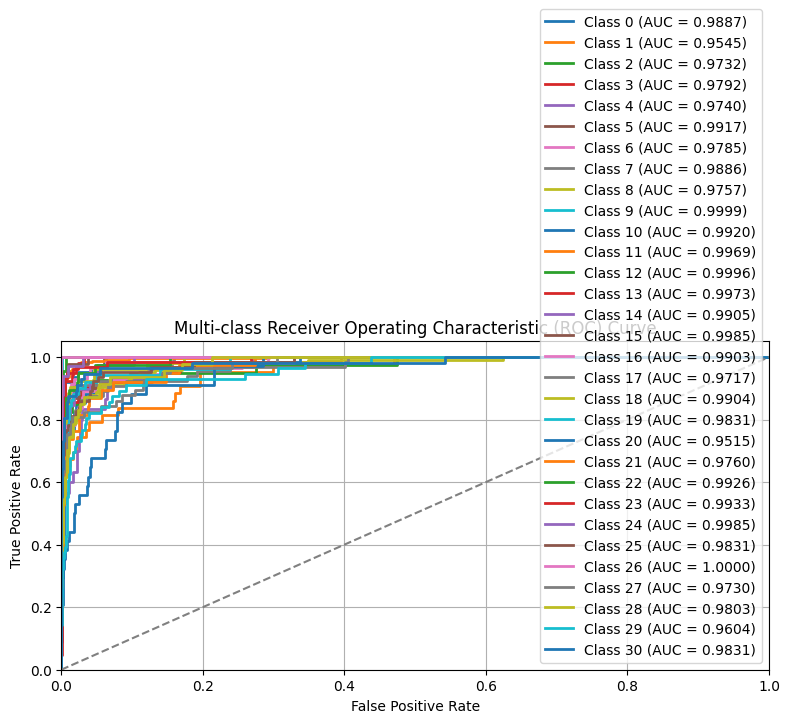

In [25]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Normalisasi probabilitas jika diperlukan (pastikan y_pred_probs sudah dalam bentuk probabilitas)
y_pred_probs = y_pred_probs / np.sum(y_pred_probs, axis=1, keepdims=True)

# Cek jumlah kelas
n_classes = y_pred_probs.shape[1]
print("Unique labels in y_test:", np.unique(y_test))

# Konversi y_test ke One-vs-Rest (biner)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Warna berbeda untuk tiap kelas
colors = cycle(plt.cm.tab10.colors)

plt.figure(figsize=(8, 6))

# Plot ROC untuk tiap kelas
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)  # Menghitung AUC untuk kelas ke-i
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.4f})')

# Menambahkan garis referensi diagonal (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Labeling dan layout
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()